<a href="https://colab.research.google.com/github/ZahraAlharz/Oxford-AI-Summer-School/blob/main/Copy_of_Oriented_YOLO_HW_CV_Oxford.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implement Oriented Bounding Box (OBB) Detection Using YOLO from scratch

In this assignment, you will create a dataset class for a subset of the Dota OBB dataset and implement Oriented YOLO from scratch.

##Dataset:
You will use a subset of Dota Dataset, consisting of 58 images. Dataset can be downloaded from:

https://universe.roboflow.com/rotated-object-detection/dota-demo/dataset/1

##Tasks:

1. Create a dataset class for the above dataset
2. Implement/Use a Backbone Network (you are allowed to use a pretrained CNN i.e., Darknet, ResNet, VGG)
3. Implement Oriented YOLO Head
5. Implement the training loop for Oriented YOLO
6. Evaluate the model on the test set


In [ ]:
from IPython.display import clear_output

## Download the dataset from roboflow API

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="NV2XEWqNLcgMkm3iBqFp")
project = rf.workspace("rotated-object-detection").project("dota-demo")
version = project.version(1)
dataset = version.download("yolov5-obb")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to DOTA-Demo-1 in yolov5-obb:: 100%|██████████| 128/128 [00:00<00:00, 4133.31it/s]


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

## Dataset Class

In [ ]:
class DOTADataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform

        self.image_dir = os.path.join(self.root_dir, self.split, 'images')
        self.label_dir = os.path.join(self.root_dir, self.split, 'labelTxt')

        self.image_files = [f for f in os.listdir(self.image_dir) if f.endswith('.png') or f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace('.png', '.txt').replace('.jpg', '.txt'))

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        boxes, labels = self.parse_labels(label_path)

        sample = {'image': image, 'boxes': boxes, 'labels': labels}

        return sample

    def parse_labels(self, label_path):
        boxes = []
        labels = []
        difficulties = []

        with open(label_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                coords = list(map(float, parts[:8]))
                label = parts[8]

                # Directly append the 8 coordinates of the OBB
                boxes.append(coords)
                labels.append(self.class_to_idx(label))

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)


        return boxes, labels

    def class_to_idx(self, class_name):
        class_dict = {'harbor': 0, 'large-vehicle': 1, 'plane': 2, 'ship': 3, 'small-vehicle': 4}  # Add all classes as necessary
        return class_dict.get(class_name)

In [ ]:
def collate_fn(batch):
    images = torch.stack([item['image'] for item in batch])
    boxes = [item['boxes'] for item in batch]
    labels = [item['labels'] for item in batch]
    return images, boxes, labels

# Define transformations
data_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# Create dataset
train_dataset = DOTADataset(root_dir='DOTA-Demo-1/', split='train', transform=data_transforms)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

# Iterate over data
for batch in train_loader:
    images, boxes, labels = batch
    print(type(images[0]))  # Should be <class 'torch.Tensor'>
    print(images.shape)     # Shape of image tensor batch
    print(len(boxes))       # Length of boxes list should be the batch size
    print(len(labels))      # Length of labels list should be the batch size
    break

<class 'torch.Tensor'>
torch.Size([8, 3, 640, 640])
8
8


In [ ]:
for batch in train_loader:
    images, boxes, labels = batch
    print(f'Batch size: {images.size(0)}')
    print(f'Image batch shape: {images.shape}')
    for i in range(len(boxes)):
        print(f'Image {i} boxes shape: {boxes[i].shape}')
        print(f'Image {i} labels shape: {labels[i].shape}')
    break  # Remove this break to iterate over the entire dataset

Batch size: 8
Image batch shape: torch.Size([8, 3, 640, 640])
Image 0 boxes shape: torch.Size([24, 8])
Image 0 labels shape: torch.Size([24])
Image 1 boxes shape: torch.Size([107, 8])
Image 1 labels shape: torch.Size([107])
Image 2 boxes shape: torch.Size([22, 8])
Image 2 labels shape: torch.Size([22])
Image 3 boxes shape: torch.Size([34, 8])
Image 3 labels shape: torch.Size([34])
Image 4 boxes shape: torch.Size([6, 8])
Image 4 labels shape: torch.Size([6])
Image 5 boxes shape: torch.Size([11, 8])
Image 5 labels shape: torch.Size([11])
Image 6 boxes shape: torch.Size([31, 8])
Image 6 labels shape: torch.Size([31])
Image 7 boxes shape: torch.Size([9, 8])
Image 7 labels shape: torch.Size([9])


## Show images from the dataset

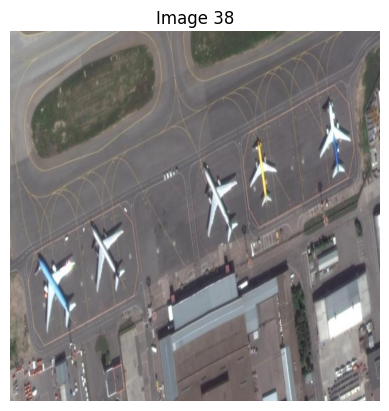

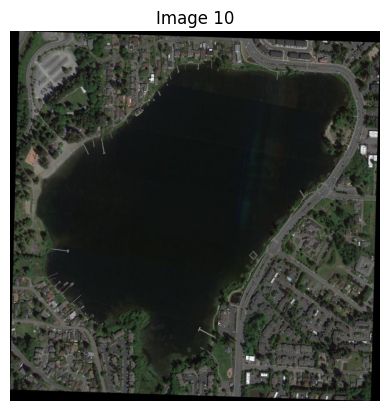

In [ ]:
import random
import matplotlib.pyplot as plt


def display_random_images(dataset, num_images=5):
    """Display random images from the dataset."""
    indices = random.sample(range(len(dataset)), num_images)
    for idx in indices:
        sample = dataset[idx]
        image = sample['image'].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        plt.imshow(image.numpy())
        plt.title(f'Image {idx}')
        plt.axis('off')
        plt.show()

# Display random images
display_random_images(train_dataset, num_images=2)

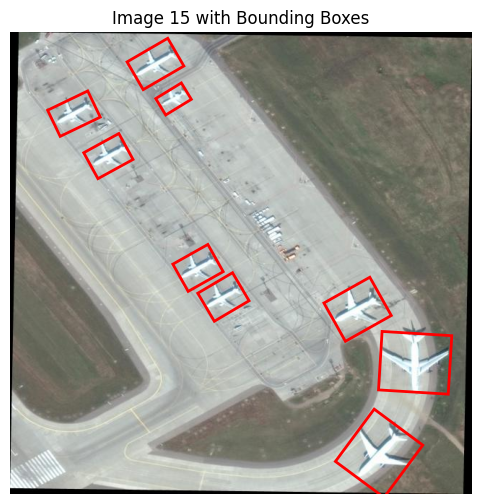

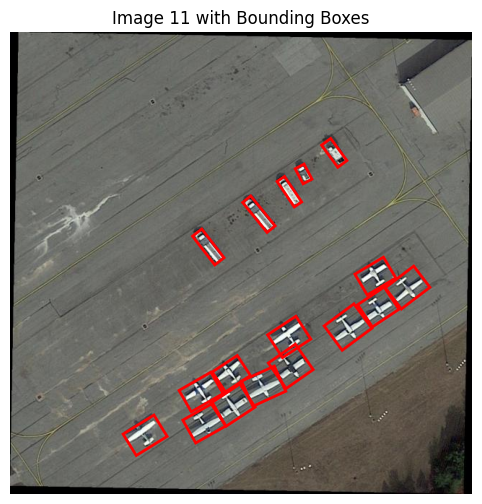

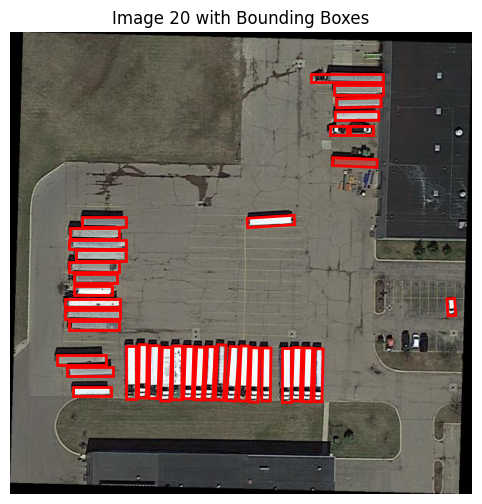

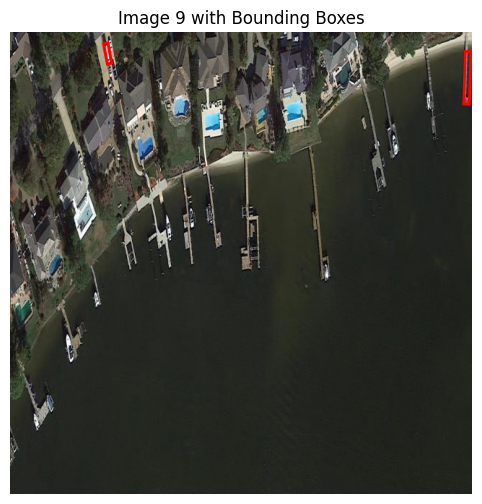

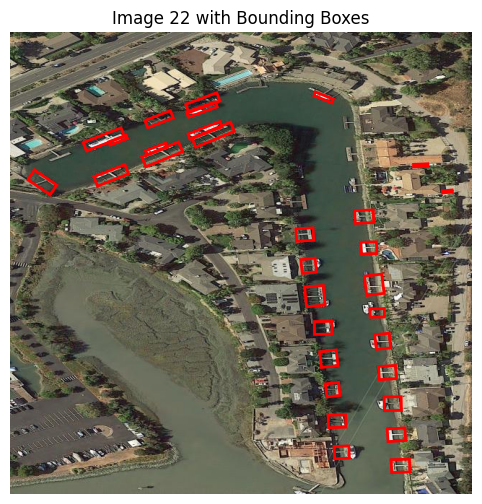

In [ ]:
import matplotlib.patches as patches
def display_random_images_with_boxes(dataset, num_images=5):
    """Display random images with their bounding boxes from the dataset."""
    indices = random.sample(range(len(dataset)), num_images)
    for idx in indices:
        sample = dataset[idx]
        image = sample['image'].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        image_np = image.numpy()

        boxes = sample['boxes'].numpy()

        # Create a figure and axes
        fig, ax = plt.subplots(1, figsize=(9, 6))
        ax.imshow(image_np)

        # Draw bounding boxes
        for box in boxes:
            # Extract coordinates
            x1, y1, x2, y2, x3, y3, x4, y4 = box[0], box[1], box[2], box[3], box[4], box[5], box[6], box[7]      # Adjust based on your bounding box format

            # Create a Rectangle patch
            rect = patches.Polygon([ (x1, y1), (x2, y2), (x3, y3), (x4, y4) ], linewidth=2, edgecolor='r', facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)

        # Display the image with bounding boxes
        plt.title(f'Image {idx} with Bounding Boxes')
        plt.axis('off')
        plt.show()

# Display random images with bounding boxes
display_random_images_with_boxes(train_dataset, num_images=5)

## YOLOv8n-obb Pretrained Model

In [ ]:
!pip install ultralytics supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
from IPython import display
from IPython.display import display, Image
import ultralytics
ultralytics.checks()
from ultralytics import YOLO
import roboflow
from roboflow import Roboflow
import supervision as sv
import cv2
import numpy as np

Ultralytics YOLOv8.2.66 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.7/78.2 GB disk)


In [ ]:
roboflow.login()

rf = Roboflow()

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········


In [ ]:
'''project = rf.workspace("rotated-object-detection").project("dota-demo")
version = project.version(1)
dataset = version.download("yolov5-obb")'''

loading Roboflow workspace...
loading Roboflow project...


### Change "labelTxt" folder name into "labels"

Change "labelTxt" folder name into "labels" as roboflow expects a certain path for images and their labels

In [ ]:
DATA_SET= dataset.location
import os

# Specify the path to the folder
def changeFolderName(folder_path):
    # Specify the current folder name
    current_folder_name = 'labelTxt'

    # Specify the new folder name
    new_folder_name = 'labels'

    # Construct the full paths for the current and new folders
    current_folder_path = os.path.join(folder_path, current_folder_name)
    new_folder_path = os.path.join(folder_path, new_folder_name)

    # Rename the folder
    os.rename(current_folder_path, new_folder_path)


changeFolderName(f"{DATA_SET}/train/")
changeFolderName(f"{DATA_SET}/valid/")
changeFolderName(f"{DATA_SET}/test/")

In [ ]:
# Define the classes and their indixs
class_names = ['harbor', 'large-vehicle', 'plane', 'ship', 'small-vehicle']
class_indixs = {name: index for index, name in enumerate(class_names)}

### Normalized Xs, Ys values

Normalized the boxes points values ( x0, y0, x1, y1, ...x7, y7). change values arrangement to be compatible with roboflow format (class_index x0, y0 ....)

In [ ]:
img_width, img_height = 640, 640

folder_path = "/content/DOTA-Demo-1/test/labels"

   # Function to normalize coordinates
def normalize_coordinates(coord, max_value):
        return float(coord) / max_value

    # Process each file in the folder
for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):  # assuming the annotation files are .txt files
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                lines = file.readlines()


            new_lines = []
            for line in lines:
                parts = line.strip().split(' ')
                if len(parts) == 10:
                    # Extract label and coordinates
                    label = parts[-2]
                    coords = parts[:8]

                    # Get the class index
                    class_index = class_indixs.get(label, -1)
                    if class_index != -1:
                        # Normalize coordinates
                        normalized_coords = [normalize_coordinates(coords[i], img_width if i % 2 == 0 else img_height) for i in range(8)]

                        # Convert to the desired format and add to new lines
                        new_line = f"{class_index} " + " ".join(map(str, normalized_coords))
                        new_lines.append(new_line)

            # Write the converted lines to a new file or overwrite the existing file
            with open(file_path, 'w') as file:
                file.write('\n'.join(new_lines))

### Train YOLOv8n-obb

In [ ]:
# Load a pretrained model
model = YOLO("yolov8n-obb.pt")

# Train the model
!yolo task=obb mode=train model=yolov8m-obb.pt data={dataset.location}/data.yaml epochs=100 imgsz=640 batch=16

100%|██████████| 6.26M/6.26M [00:00<00:00, 357MB/s]


100% 50.9M/50.9M [00:01<00:00, 37.5MB/s]
Ultralytics YOLOv8.2.66 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=obb, mode=train, model=yolov8m-obb.pt, data=/content/DOTA-Demo-1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop

### Visualize Training results

it seems that the model performe poorly, may due to the dataset size, 40 images for training and 12 images for evaluation

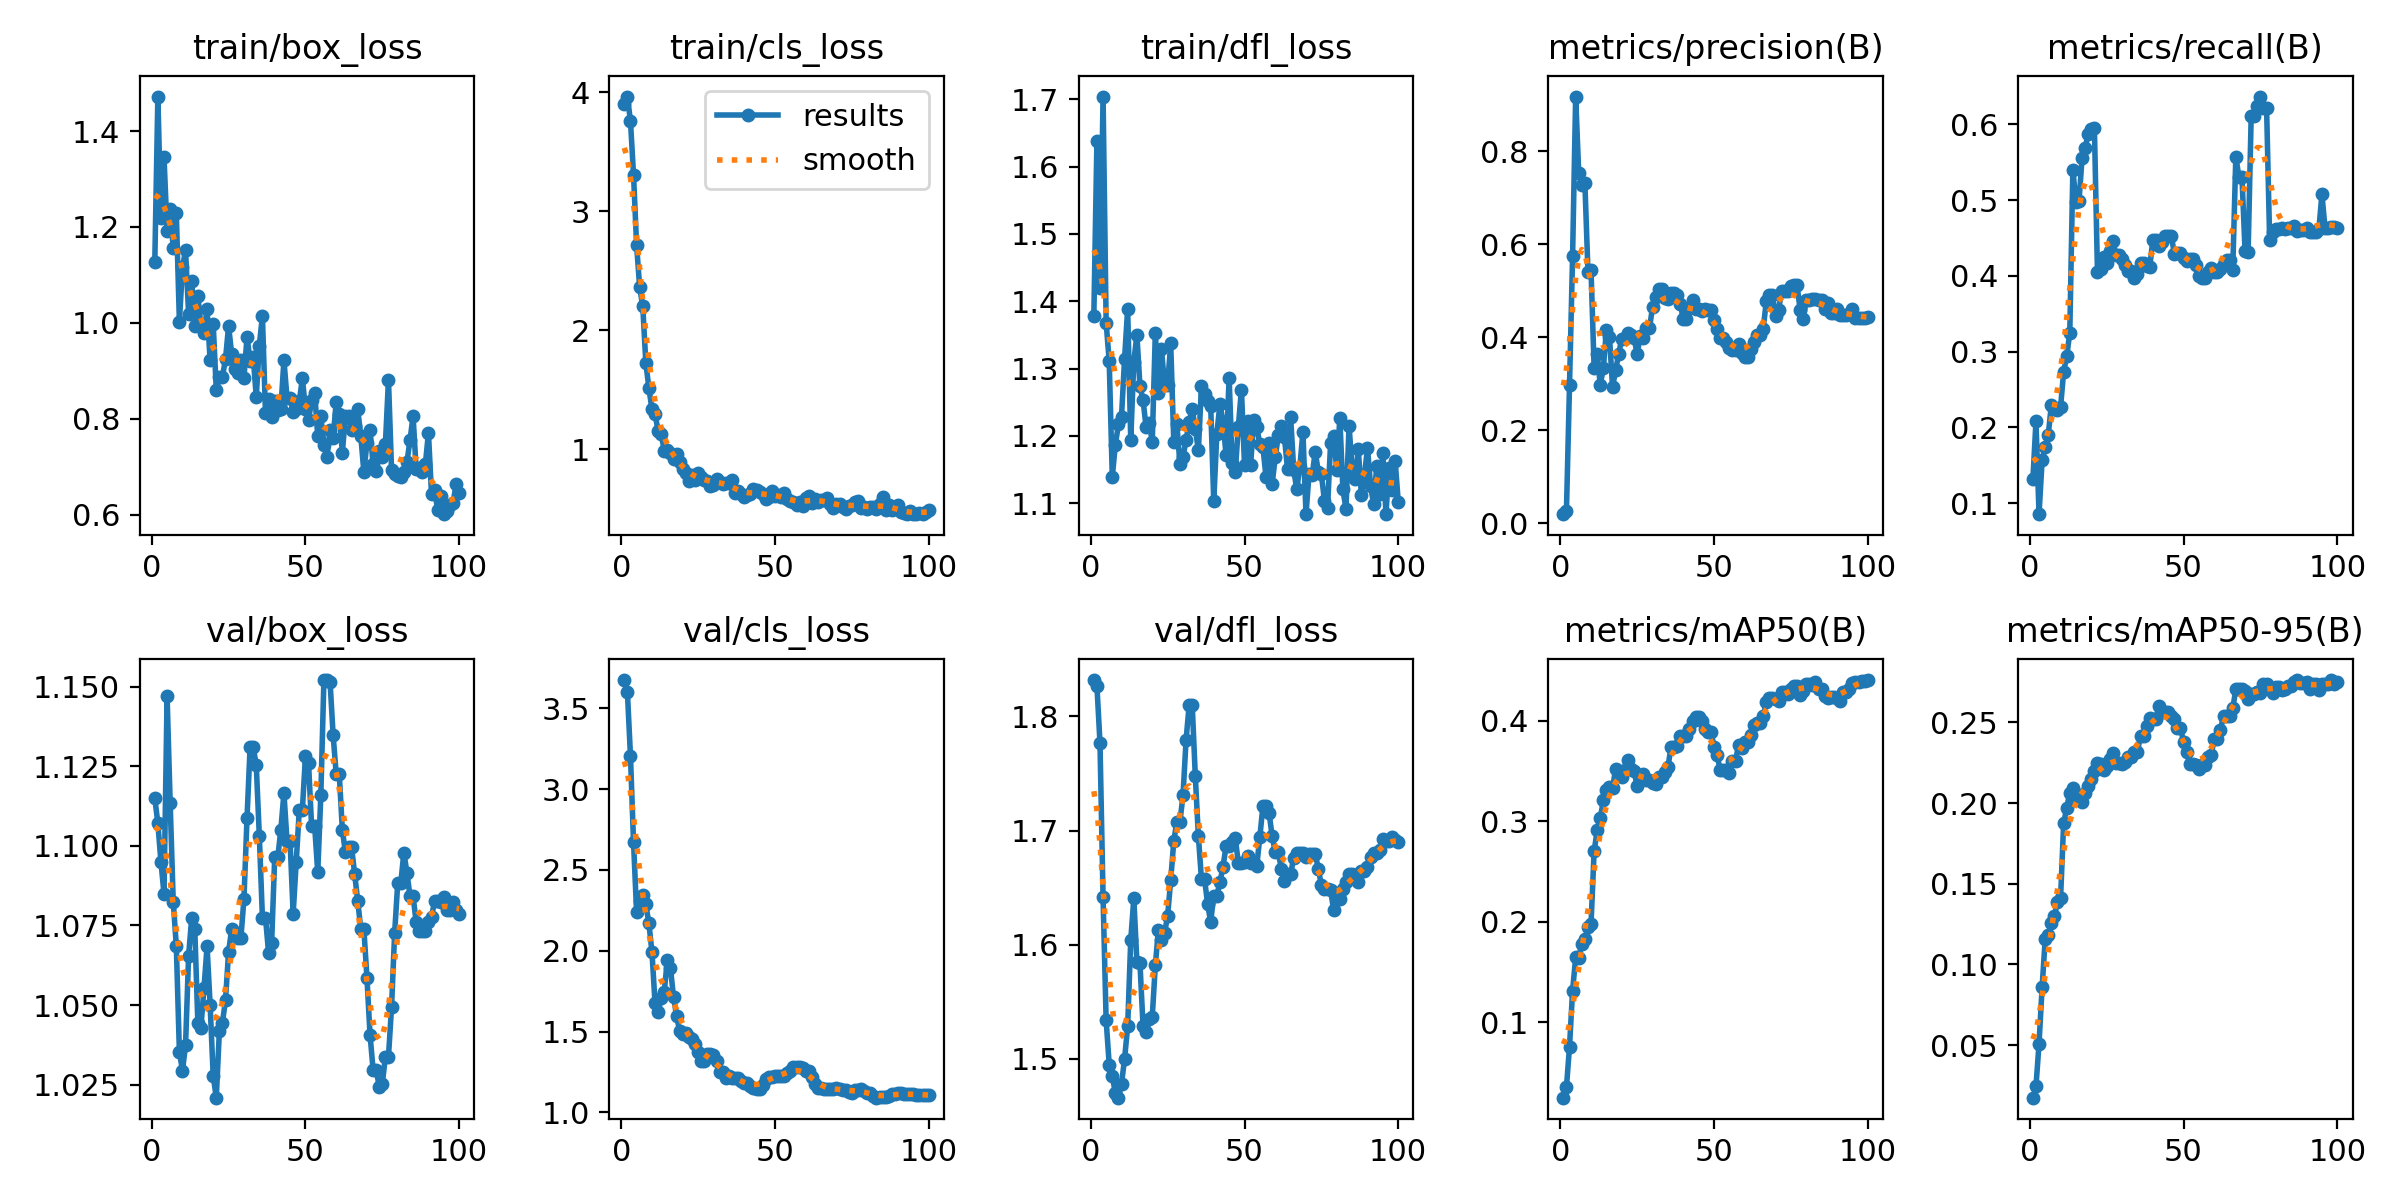

In [ ]:
Image(filename=f'runs/obb/train/results.png', width=1400)

### Make Prediction on the Test Data

In [ ]:
!yolo task=obb mode=predict model=runs/obb/train/weights/best.pt conf=0.4 source="DOTA-Demo-1/test/images" save=true

Ultralytics YOLOv8.2.66 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-obb summary (fused): 237 layers, 26,402,962 parameters, 0 gradients, 80.8 GFLOPs

image 1/6 /content/DOTA-Demo-1/test/images/P0038_png.rf.717d38ff8ca98872172a2b94af2ba047.jpg: 640x640 38.6ms
image 2/6 /content/DOTA-Demo-1/test/images/P0344_png.rf.c7af375b3f56c6866fccd9486c7cc7a6.jpg: 640x640 38.6ms
image 3/6 /content/DOTA-Demo-1/test/images/P0378_png.rf.6fba56d1ac7ccaf6e342b32b21277f6f.jpg: 640x640 38.5ms
image 4/6 /content/DOTA-Demo-1/test/images/P0878_png.rf.a793dcd9ea18460b438a355616d8db80.jpg: 640x640 (no detections), 32.9ms
image 5/6 /content/DOTA-Demo-1/test/images/P1114_png.rf.262ab0ab30e759fc48242e58d4d07dfd.jpg: 640x640 31.1ms
image 6/6 /content/DOTA-Demo-1/test/images/P1144_png.rf.63ca3c72d4bebb446ab0aec2eac229e8.jpg: 640x640 31.2ms
Speed: 1.8ms preprocess, 35.1ms inference, 67.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/obb/predict
💡 Learn more at http

### Show Prediction on the Test images

In [ ]:
import yaml
import matplotlib.pyplot as plt

Ground Truth:


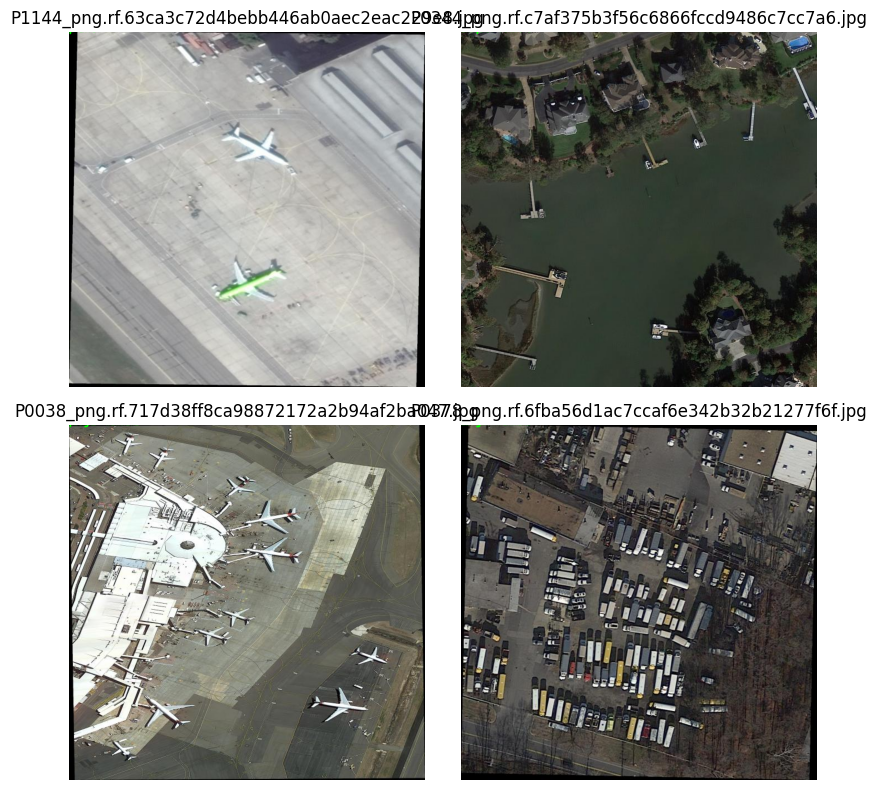

In [ ]:
# Function to draw boxes on images
def draw_boxes(image, annotations, color, label_map):
    for annotation in annotations:
        parts = annotation.strip().split(' ')
        label = int(parts[0])
        coords = list(map(float, parts[1:]))
        points = [(coords[i], coords[i + 1]) for i in range(0, len(coords), 2)]
        points = np.array(points, dtype=np.int32).reshape((-1, 1, 2))
        cv2.polylines(image, [points], isClosed=True, color=color, thickness=2)
        cv2.putText(image, label_map[label], tuple(points[0][0]), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

# Load class names
with open(f"{dataset.location}/data.yaml") as f:
    data = yaml.load(f, Loader=yaml.FullLoader)
    label_map = {i: name for i, name in enumerate(data['names'])}

# Visualize ground truth and predicted images
def visualize_images(images, titles, grid_size, plot_size):
    fig, axs = plt.subplots(*grid_size, figsize=plot_size)
    axs = axs.flatten()
    for img, title, ax in zip(images, titles, axs):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Prepare paths
ground_truth_folder = f"{dataset.location}/test/images"
predicted_folder = "runs/obb/predict"

# Get image paths
image_paths = sv.list_files_with_extensions(directory=predicted_folder, extensions=["png", "jpg", "jpeg"])

# Helper function to find annotation file
def find_annotation_file(folder, base_name):
    for ext in ['.txt']:
        candidate_path = os.path.join(folder, base_name + ext)
        if os.path.exists(candidate_path):
            return candidate_path
    return None

# Select 4 images for visualization
sample_images = image_paths[:4]

# Load and annotate images
ground_truth_images = []
predicted_images = []
for img_path in sample_images:
    img_name = os.path.basename(img_path)
    gt_img = cv2.imread(os.path.join(ground_truth_folder, img_name))
    pred_img = cv2.imread(str(img_path))

    base_name = os.path.splitext(img_name)[0]
    gt_annotation_path = find_annotation_file(f"{dataset.location}/test/labels", base_name)

    if gt_annotation_path:
        with open(gt_annotation_path, 'r', encoding='utf-8') as f:
            gt_annotations = f.readlines()
    else:
        gt_annotations = []
        print(f"Ground truth annotation for {img_name} not found.")

    #draw_boxes(gt_img, gt_annotations, (0, 255, 0), label_map)  # Green for ground truth

    ground_truth_images.append(gt_img)
    predicted_images.append(pred_img)

# Visualize images
print("Ground Truth:")
visualize_images(ground_truth_images, [os.path.basename(p) for p in sample_images], (2, 2), (8, 8))

Predictions:


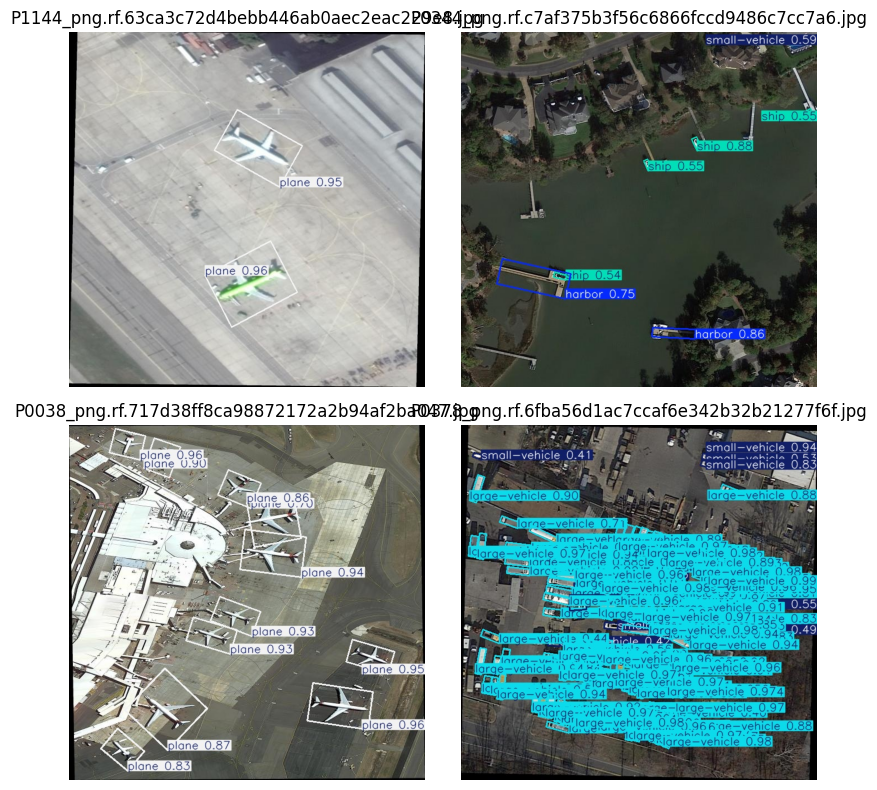

In [ ]:
print("Predictions:")
visualize_images(predicted_images, [os.path.basename(p) for p in sample_images], (2, 2), (8, 8))

# Build YOLO Model from Scratch

**we need to modify the YOLOv1 model to handle OBBs. This involves changing the output layer to predict 8 coordinates for each bounding box instead of the usual 4.**

In [ ]:
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import VOCDetection
from tqdm import tqdm
seed = 123
torch.manual_seed(seed)
from collections import Counter

## Model Architecture

In [ ]:
architecture_config = [
    #Tuple: (kernel_size, number of filters, strides, padding)
    (7, 64, 2, 3),
    #"M" = Max Pool Layer
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    #List: [(tuple), (tuple), how many times to repeat]
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
    #Doesnt include fc layers
]

In [ ]:
import torch
import torch.nn as nn

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

class YoloV1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(YoloV1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [CNNBlock(in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3])]
                in_channels = x[1]
            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            elif type(x) == list:
                conv1 = x[0] #Tuple
                conv2 = x[1] #Tuple
                repeats = x[2] #Int

                for _ in range(repeats):
                    layers += [CNNBlock(in_channels, conv1[1], kernel_size=conv1[0], stride=conv1[2], padding=conv1[3])]
                    layers += [CNNBlock(conv1[1], conv2[1], kernel_size=conv2[0], stride=conv2[2], padding=conv2[3])]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 9))  # B * 9: 8 coordinates + 1 confidence
        )

## Intersection Over Union

In [ ]:
from shapely.geometry import Polygon

def obb_iou(box1, box2):
    poly1 = Polygon([(box1[0], box1[1]), (box1[2], box1[3]), (box1[4], box1[5]), (box1[6], box1[7])])
    poly2 = Polygon([(box2[0], box2[1]), (box2[2], box2[3]), (box2[4], box2[5]), (box2[6], box2[7])])

    if not poly1.is_valid or not poly2.is_valid:
        return 0.0

    intersection_area = poly1.intersection(poly2).area
    union_area = poly1.union(poly2).area

    return intersection_area / union_area

## Non-Max Supression

In [ ]:
def non_max_suppression_obb(predictions, iou_threshold, threshold):
    """
    predictions: List of lists where each list represents a bounding box with 8 coordinates and score.
    """
    assert type(predictions) == list

    # Filter out boxes below the confidence threshold
    predictions = [box for box in predictions if box[1] > threshold]

    if len(predictions) == 0:
        return []

    # Sort boxes by confidence score
    predictions = sorted(predictions, key=lambda x: x[1], reverse=True)

    selected_boxes = []

    while predictions:
        chosen_box = predictions.pop(0)
        selected_boxes.append(chosen_box)

        # Filter out boxes that have high IOU with the chosen box
        predictions = [
            box for box in predictions
            if obb_iou(chosen_box[2:], box[2:]) < iou_threshold
        ]

    return selected_boxes

## Mean Average Precision

In [ ]:
def mean_average_precision(pred_boxes, true_boxes, iou_threshold, num_classes):
    """
    pred_boxes: List of lists [train_idx, class_prediction, prob_score, x1, y1, x2, y2, ..., x7, y7]
    true_boxes: List of lists [train_idx, class_label, x1, y1, x2, y2, ..., x7, y7]
    """
    average_precisions = []

    for c in range(num_classes):
        detections = [box for box in pred_boxes if box[1] == c]
        ground_truths = [box for box in true_boxes if box[1] == c]

        num_gts = len(ground_truths)
        if num_gts == 0:
            continue

        tp = [0] * len(detections)
        fp = [0] * len(detections)
        total_true_boxes = len(ground_truths)

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [gt for gt in ground_truths if gt[0] == detection[0]]

            best_iou = 0
            for gt in ground_truth_img:
                iou = obb_iou(detection[2:], gt[2:])
                if iou > best_iou:
                    best_iou = iou
                    best_gt = gt

            if best_iou > iou_threshold:
                if best_gt in ground_truth_img:
                    tp[detection_idx] = 1
                    ground_truth_img.remove(best_gt)
                else:
                    fp[detection_idx] = 1
            else:
                fp[detection_idx] = 1

        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)

        recalls = tp_cumsum / (total_true_boxes + 1e-6)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
        precisions = np.concatenate(([1], precisions))
        recalls = np.concatenate(([0], recalls))

        average_precisions.append(np.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [ ]:
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval mode before getting bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        pred_bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression_obb(
                pred_bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

def convert_cellboxes(predictions, S=7, C=5):
    """
    Converts bounding boxes output from YOLO with an image split size of S
    into entire image ratios rather than relative to cell ratios.
    """
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, S, S, C + 10)
    bboxes1 = predictions[..., C + 1:C + 9]
    bboxes2 = predictions[..., C + 10:C + 18]
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 9].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(S).repeat(batch_size, S, 1).unsqueeze(-1)
    x_coords = (best_boxes[..., 0:8:2] + cell_indices) * (1 / S)
    y_coords = (best_boxes[..., 1:8:2] + cell_indices.permute(0, 2, 1, 3)) * (1 / S)
    converted_bboxes = torch.cat((x_coords, y_coords), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 9]).unsqueeze(-1)
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes


## YOLO Loss for OBBs

**We will need to update the loss function to compute the loss for 8 coordinates instead of 4**

In [ ]:
import torch.nn.functional as F

class YoloLoss_OBB(nn.Module):
    def __init__(self, S=7, B=2, C=5):
        super(YoloLoss_OBB, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in dataset 5),
        """
        self.S = S
        self.B = B
        self.C = C
        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # Reshape predictions to (batch_size, S, S, C + B * 9)
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 9)

        iou_b1 = obb_iou(predictions[..., 21:29], target[..., 21:29])
        iou_b2 = obb_iou(predictions[..., 30:38], target[..., 30:38])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Continue with rest of the loss calculations similar to YOLO but using OBB iou and 8-point boxes
        # Code assumes target and predictions both include 8-point coordinates for OBBs and confidences

        # Extract target values
        obj = target[..., 20].unsqueeze(3)
        no_obj = 1 - obj

        # Localization loss
        loc_loss = self.mse(
            torch.flatten(obj * predictions[..., 21:29], end_dim=-2),
            torch.flatten(obj * target[..., 21:29], end_dim=-2),
        )

        # Confidence loss for obj
        conf_loss_obj = self.mse(
            torch.flatten(obj * predictions[..., 20:21], end_dim=-2),
            torch.flatten(obj * ious.unsqueeze(3), end_dim=-2),
        )

        # Confidence loss for no obj
        conf_loss_no_obj = self.mse(
            torch.flatten(no_obj * predictions[..., 20:21], end_dim=-2),
            torch.flatten(no_obj * target[..., 20:21], end_dim=-2),
        )

        # Class loss
        class_loss = self.mse(
            torch.flatten(obj * predictions[..., :20], end_dim=-2),
            torch.flatten(obj * target[..., :20], end_dim=-2),
        )

        # Total loss
        loss = (
            self.lambda_coord * loc_loss +
            conf_loss_obj +
            self.lambda_noobj * conf_loss_no_obj +
            class_loss
        )

        return loss

## Hyperparameters Tuning

In [ ]:
# Hyperparameters
LEARNING_RATE = 2e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
WEIGHT_DECAY = 0
EPOCHS = 10
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "model.pth"

In [ ]:
# Custom Compose class for transforming images and bounding boxes
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes
        return img, bboxes

In [ ]:
# Dataset and DataLoader
transform = transforms.Compose([
    #transforms.Resize((448, 448), antialias=None),
    transforms.ToTensor(),
])

In [ ]:
train_dataset = DOTADataset(root_dir='DOTA-Demo-1/', split='train', transform=transform)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False,
    num_workers=NUM_WORKERS,
    #pin_memory=PIN_MEMORY,
    collate_fn=collate_fn
)

## Model initailization

In [ ]:
# Model, optimizer, and loss function
model = YoloV1(split_size=7, num_boxes=2, num_classes=5)  # Adjust num_classes according to your dataset
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1, patience=3, mode='max', verbose=True)
loss_fn = YoloLoss_OBB(C=5)  # Adjust C to match the number of classes

#if LOAD_MODEL:
  #load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

model.to(DEVICE)

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.


YoloV1(
  (darknet): Sequential(
    (0): CNNBlock(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): CNNBlock(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): CNNBlock(
      (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (5): CNNBloc

In [ ]:
for batch in train_loader:
    images, boxes, labels = batch
    print(f'Batch size: {images.size(0)}')
    print(f'Image batch shape: {images.shape}')
    for i in range(len(boxes)):
        print(f'Image {i} boxes shape: {boxes[i].shape}')
        print(f'Image {i} labels shape: {labels[i].shape}')
    break  # Remove this break to iterate over the entire dataset

Batch size: 16
Image batch shape: torch.Size([16, 3, 640, 640])
Image 0 boxes shape: torch.Size([5, 8])
Image 0 labels shape: torch.Size([5])
Image 1 boxes shape: torch.Size([132, 8])
Image 1 labels shape: torch.Size([132])
Image 2 boxes shape: torch.Size([24, 8])
Image 2 labels shape: torch.Size([24])
Image 3 boxes shape: torch.Size([6, 8])
Image 3 labels shape: torch.Size([6])
Image 4 boxes shape: torch.Size([15, 8])
Image 4 labels shape: torch.Size([15])
Image 5 boxes shape: torch.Size([9, 8])
Image 5 labels shape: torch.Size([9])
Image 6 boxes shape: torch.Size([8, 8])
Image 6 labels shape: torch.Size([8])
Image 7 boxes shape: torch.Size([16, 8])
Image 7 labels shape: torch.Size([16])
Image 8 boxes shape: torch.Size([12, 8])
Image 8 labels shape: torch.Size([12])
Image 9 boxes shape: torch.Size([1, 8])
Image 9 labels shape: torch.Size([1])
Image 10 boxes shape: torch.Size([150, 8])
Image 10 labels shape: torch.Size([150])
Image 11 boxes shape: torch.Size([13, 8])
Image 11 labels sh

## Training Loop

In [ ]:
# Training loop
for epoch in range(EPOCHS):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (images, boxes, labels) in enumerate(loop):
        images = images.to(DEVICE)
        boxes = [box.to(DEVICE) for box in boxes]
        labels = [label.to(DEVICE) for label in labels]

        out = model(images)
        loss = loss_fn(out, boxes, labels)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss) / len(mean_loss)}")

    pred_boxes, target_boxes = get_bboxes(
        train_loader, model, iou_threshold=0.5, threshold=0.4, box_format="corners"
    )

    mean_avg_prec = mean_average_precision(
        pred_boxes, target_boxes, iou_threshold=0.5, box_format="corners"
    )
    print(f"Train mAP: {mean_avg_prec}")

    # Uncomment if using the learning rate scheduler
    # scheduler.step(mean_avg_prec)

print('Training done.')

  0%|          | 0/3 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x102400 and 50176x496)

In [ ]:
# Visualization of sample predictions
n_samples = 5
sample_instances = [train_dataset[i] for i in random.sample(range(len(train_dataset)), n_samples)]

for img, label in sample_instances:
    img = img.to(DEVICE)
    with torch.no_grad():
        pred = model(img.unsqueeze(0))[0]
        pred = pred.reshape(label.shape).cpu().numpy()

    print('Original:')
    draw_boxes(img, label, list(voc_classes.keys()))

    print('Predicted:')
    draw_boxes(img, pred, list(voc_classes.keys()))